# 4. Multilayer Perceptron with Pytorch
First, get an overview of the folder structure. In the main folder should be the three folders:
* `train`
* `val`
* `test`


Each of these folders contains 10 subfolders, named 0, 1, ..., 9. Each of these folders contains grayscale images in png format.

## 1. Read Data


In [4]:
# Um Klassendefinition auf mehrere Zellen aufteilen zu können.
# !{sys.executable} -m pip install jdc
import jdc
import os
import sys
# Ich hab hier den pfad mit KI_Übung_4 erweitert, weil hier die Daten gespeichert waren
root_dir = os.path.abspath('..') + os.sep + "KI_Übung_4"+ os.sep + "MNIST_IMG" + os.sep # os.getcwd() + os.sep + "MNIST_IMG" + os.sep

#### Seeds setzen (optional)
Die Gewichte der Modelle werden in der Regel zufällig belegt, außerdem werden die Samples im Dataloader oft gemischt. Somit entsteht sehr viel Zufall, sodass die Ergebnisse mit gleichen Hyperparametern stark abweichen können. Damit die Ergebnisse reproduzierbar sind, setzen wir entsprechende Seeds und deterministic-flags.

In [1]:
import numpy as np
import torch
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 2. Dataloader
Now create a subclass of the class Dataset of `torch.utils.data`. To do this, you need to override the following three methods:

*   `__init__(self)` This constructor should specify the dataset we want to use. Either `train or val`
*   `__len__(self)` The size of the Dataset.
*   `__getitem__(self, idx)` The Parameter `idx` specifies the sample to be loaded.


In [2]:
import glob
import torch
import torchvision
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset
from PIL import Image


class Simple_Dataloader(Dataset):
    def __init__(self, root_dir, loader_mode):
        self.imgs = [] 
        self.img_paths = []
        self.root_dir = root_dir
        self.loader_mode = loader_mode
        for i in range(10):
            self.img_paths += glob.glob(root_dir + os.sep + loader_mode + os.sep + str(i) + '/*.png')
        
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        self.imgs.append(img)
        parent_dir_path = os.path.dirname(self.img_paths[idx])
        lbl = os.path.basename(parent_dir_path)
        
        # Transform PIL Image into Pytorch Tensor
        img_torch = self.transform(img)
        # Flatten Tensor
        img_flattened = torch.flatten(img_torch)
        
        return img_flattened, torch.tensor(int(lbl))

## 3. From Dataset to Dataloader


In [3]:
batch_size_train = 1 # 88
batch_size_val = 1

seed_everything(1)

print("Cache Data:")

train_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="train")
val_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="val")
test_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="test")


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=True,
                                               shuffle=True, drop_last=False)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, pin_memory=True,
                                             shuffle=False, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, pin_memory=True,
                                              shuffle=False, drop_last=False)



for i in tqdm(range(len(train_dataloader))):
    train_dataset.__getitem__(i)
for i in tqdm(range(len(val_dataloader))):
    val_dataset.__getitem__(i)
for i in tqdm(range(len(test_dataloader))):
    test_dataset.__getitem__(i)



dataset_sizes = dict()
dataset_sizes["train"] = len(train_dataset.imgs)
dataset_sizes["val"] = len(val_dataset.imgs)
dataset_sizes["test"] = len(test_dataset.imgs)
dataset_sizes

NameError: name 'os' is not defined

## 4. Definition of the Model
Now we are ready to define our first MLP. For this, let's consider the following model template:
```
input_layer = nn.Linear(784, 128)
hidden1 = nn.Linear(128, 64)
output_layer = nn.Linear(64, 10)
```
In this task, we consider only Fully-Connected Layers. 

In [5]:
import torch.nn as nn

class Our_first_MLP(nn.Module):
    def __init__(self):
        super(Our_first_MLP, self).__init__()
        
        self.input_layer = nn.Linear(784, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 10)

        
    def forward(self, x):
        x1 = torch.nn.functional.relu(self.input_layer(x))
        x2 = torch.nn.functional.relu(self.hidden1(x1))
        x_out = torch.nn.functional.relu(self.output_layer(x2))
        return x_out

        

## 5. Lossfunktion and Defining Hyperparameters.


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Our_first_MLP()
model = model.to(device)

cur_lr = 0.001



optimizer = torch.optim.SGD(model.parameters(), lr=cur_lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=cur_lr)

# Define a reasonable Loss function
criterion = nn.CrossEntropyLoss()


num_epochs = 15


## 6. Implement Training und Validation.




In [11]:
import sys
from tqdm import tqdm
import copy


def train_model(train_dataloader, val_dataloader):
    # Initialize best validation loss to a large value and best model weights as current model weights
    best_val_loss = sys.float_info.max
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        # Set the model in training mode
        phase = 'train'
        model.train()
        running_loss = 0.0
        with torch.set_grad_enabled(phase == 'train'):
            # Iterate over the training data
            for inputs, labels in tqdm(train_dataloader, leave=True):
                # Move data to the device
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Zero the gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(inputs)
                # Compute the loss
                loss = criterion(outputs, labels)
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                # Accumulate the training loss
                running_loss += loss.item()
            # Compute average training loss and
            train_loss = running_loss / len(train_dataloader)
            print('Epoch {} train loss: {:.4f}'.format(epoch + 1, train_loss))
        
        # Set the model in evaluation mode
        phase = 'eval'
        model.eval()
        running_loss = 0.0
        with torch.set_grad_enabled(phase == 'eval'):
            # Iterate over the validation data
            for inputs, labels in tqdm(val_dataloader, leave=True):
                # Move data to the device
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass 
                outputs = model(inputs)
                # Compute the loss
                loss = criterion(outputs, labels)
                # Accumulate the validation loss
                running_loss += loss.item()
            # Compute average validation loss
            val_loss = running_loss / len(val_dataloader)
            print('Epoch {} val loss: {:.4f}'.format(epoch + 1, val_loss))
            # Save the model with the best validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'best_model.pth')
                print('New best model found and saved.')


### 6.1. Training durchführen
Führen Sie die Trainingsmethode aus.

In [12]:
train_model(train_dataloader, val_dataloader)

100%|██████████| 42152/42152 [01:07<00:00, 627.97it/s]


Epoch 1 train loss: 0.2919


100%|██████████| 17848/17848 [00:13<00:00, 1295.22it/s]


Epoch 1 val loss: 0.3203
New best model found and saved.


100%|██████████| 42152/42152 [01:04<00:00, 654.14it/s]


Epoch 2 train loss: 0.2856


100%|██████████| 17848/17848 [00:13<00:00, 1287.52it/s]


Epoch 2 val loss: 0.3210


100%|██████████| 42152/42152 [00:59<00:00, 712.08it/s]


Epoch 3 train loss: 0.2810


100%|██████████| 17848/17848 [00:13<00:00, 1309.06it/s]


Epoch 3 val loss: 0.3197
New best model found and saved.


100%|██████████| 42152/42152 [00:59<00:00, 712.41it/s]


Epoch 4 train loss: 0.2761


100%|██████████| 17848/17848 [00:13<00:00, 1324.63it/s]


Epoch 4 val loss: 0.3193
New best model found and saved.


100%|██████████| 42152/42152 [01:06<00:00, 631.70it/s]


Epoch 5 train loss: 0.2722


100%|██████████| 17848/17848 [00:17<00:00, 1047.34it/s]


Epoch 5 val loss: 0.3149
New best model found and saved.


100%|██████████| 42152/42152 [01:03<00:00, 664.60it/s]


Epoch 6 train loss: 0.2683


100%|██████████| 17848/17848 [00:15<00:00, 1174.31it/s]


Epoch 6 val loss: 0.3153


100%|██████████| 42152/42152 [01:03<00:00, 665.98it/s]


Epoch 7 train loss: 0.2646


100%|██████████| 17848/17848 [00:16<00:00, 1098.54it/s]


Epoch 7 val loss: 0.3211


100%|██████████| 42152/42152 [00:59<00:00, 711.90it/s]


Epoch 8 train loss: 0.2617


100%|██████████| 17848/17848 [00:14<00:00, 1231.76it/s]


Epoch 8 val loss: 0.3158


100%|██████████| 42152/42152 [01:06<00:00, 635.53it/s]


Epoch 9 train loss: 0.2586


100%|██████████| 17848/17848 [00:16<00:00, 1050.36it/s]


Epoch 9 val loss: 0.3191


100%|██████████| 42152/42152 [01:15<00:00, 557.29it/s]


Epoch 10 train loss: 0.2559


100%|██████████| 17848/17848 [00:16<00:00, 1099.72it/s]


Epoch 10 val loss: 0.3136
New best model found and saved.


100%|██████████| 42152/42152 [01:19<00:00, 531.52it/s]


Epoch 11 train loss: 0.2542


100%|██████████| 17848/17848 [00:16<00:00, 1082.67it/s]


Epoch 11 val loss: 0.3185


100%|██████████| 42152/42152 [01:20<00:00, 524.76it/s]


Epoch 12 train loss: 0.2522


100%|██████████| 17848/17848 [00:17<00:00, 1043.67it/s]


Epoch 12 val loss: 0.3194


100%|██████████| 42152/42152 [01:08<00:00, 619.83it/s]


Epoch 13 train loss: 0.2501


100%|██████████| 17848/17848 [00:13<00:00, 1302.10it/s]


Epoch 13 val loss: 0.3152


100%|██████████| 42152/42152 [00:59<00:00, 708.71it/s]


Epoch 14 train loss: 0.2486


100%|██████████| 17848/17848 [00:12<00:00, 1423.52it/s]


Epoch 14 val loss: 0.3181


100%|██████████| 42152/42152 [00:49<00:00, 848.32it/s]


Epoch 15 train loss: 0.2467


100%|██████████| 17848/17848 [00:12<00:00, 1466.31it/s]

Epoch 15 val loss: 0.3174


## 7. Evaluation
### 7.1. Calculate the metrics
Implement a function that calculates the evaluation metrics of a confusion matrix.

In [39]:
def calc_metrics(confusion_matrix):
    # Initialize variables for true positives, false positives, and false negatives
    tp = np.diag(confusion_matrix)
    fp = np.sum(confusion_matrix, axis=0) - tp
    fn = np.sum(confusion_matrix, axis=1) - tp
    # Compute precision, recall, and F1-score
    precision = np.nan_to_num(tp / (tp + fp))
    recall = np.nan_to_num(tp / (tp + fn))
    f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall))
    return precision, recall, f1_score

### 7.2. Implement a Test-Funktion 
The function should work the same way as the validation phase but it should not calculate the loss. This test function will be used later on to in the calculation of the confusion matrix.

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix

def test_model(test_dataset, save_data=True):
    # Set model to evaluation mode
    model.eval()
    # Initialize lists to store the true labels and predictions
    true_labels = []
    pred_labels = []
    # Iterate over the data
    for inputs, labels in test_dataset:
        # Move data to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Get model predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 0)
        # Append true labels and predictions to the lists
        true_labels.append(labels.item())
        pred_labels.append(preds.item())
    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    return cm

### 7.3. Run Tests
Run the Test und give the Precision, Recall and F1-Score.

In [40]:
cm = test_model(test_dataset)
print(cm)
pS, rS, f1S = calc_metrics(cm)
print("precision:", pS)
print("recall:", rS)
print("F1_Score:", f1S)

[[ 965    0    2    1    0    4    5    1    2    0]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   2    5 1013    0    0    0    2    6    4    0]
 [   2    0    7  990    0    4    0    4    3    0]
 [   7    1    2    0  962    0    7    2    1    0]
 [   5    1    2   12    1  854    6    1   10    0]
 [   3    2    1    1    4    2  942    1    2    0]
 [   7   10    7    7    1    1    0  993    2    0]
 [   4    1    4    6    2    4    6    1  946    0]
 [ 928    6    3   10   19   11    2   12   18    0]]
precision: [0.50182007 0.97743056 0.97123682 0.96303502 0.9726997  0.96935301
 0.9691358  0.97162427 0.95555556 0.        ]
recall: [0.98469388 0.99207048 0.98158915 0.98019802 0.9796334  0.9573991
 0.98329854 0.96595331 0.97125257 0.        ]
F1_Score: [0.66482949 0.98469611 0.97638554 0.97154073 0.97615424 0.96333897
 0.9761658  0.96878049 0.96334012 0.        ]


C:\Users\maxko\AppData\Local\Temp\ipykernel_19492\2918465507.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.nan_to_num(tp / (tp + fp))
C:\Users\maxko\AppData\Local\Temp\ipykernel_19492\2918465507.py:9: RuntimeWarning: invalid value encountered in divide
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall))


## 8. Visualize the Results
Use a Confusion Matrix.

Recall: [0.98469388 0.99207048 0.98158915 0.98019802 0.9796334  0.9573991
 0.98329854 0.96595331 0.97125257 0.        ]
Precision: [0.50182007 0.97743056 0.97123682 0.96303502 0.9726997  0.96935301
 0.9691358  0.97162427 0.95555556 0.        ]
F1-Score: [0.66482949 0.98469611 0.97638554 0.97154073 0.97615424 0.96333897
 0.9761658  0.96878049 0.96334012 0.        ]


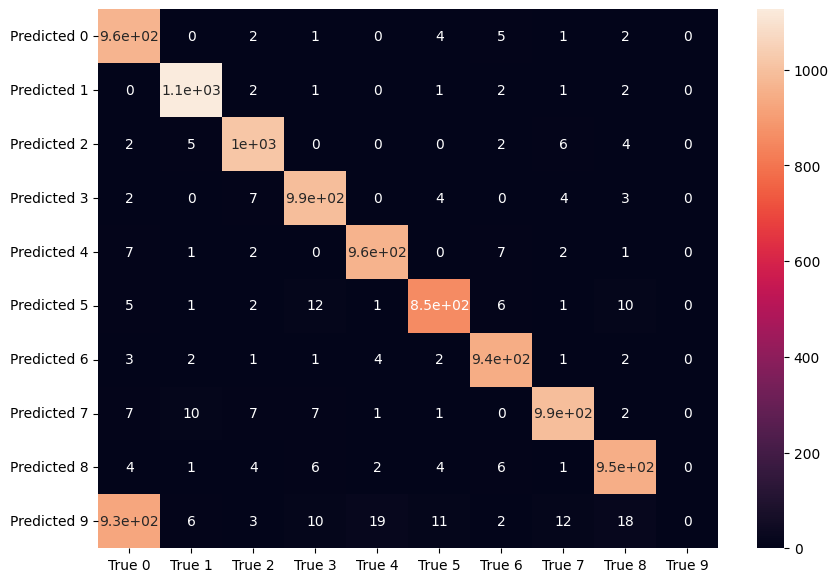

In [42]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ["Predicted 0" ,"Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7","Predicted 8","Predicted 9"],
                  columns = ["True 0", "True 1","True 2","True 3","True 4","True 5","True 6","True 7","True 8","True 9"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

print("Recall: " + str(rS))

print("Precision: " + str(pS))

print("F1-Score: " + str(f1S))